# Monitor Training and Plotting

---
---

#### Import policy, RL agent, Wrappers
---

In [1]:
import os

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from deeprl import DQN
from deeprl.common.monitor import Monitor
from deeprl.common.results_plotter import load_results, ts2xy
from deeprl.common.noise import NormalActionNoise
from deeprl.common.callbacks import BaseCallback

#### Define a Callback Function
---

In [11]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    base on the training reward (in practice, we recommend using ``EvalCallback``).
    
    :param check_freq: (int)
    :param log_dir: (str) Path to the folder where the model will be saved.
        It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: (int)
    """
    
    def __init__(self, check_freq: int, log_dir: str, verbose=1):
        super().__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf
        
    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)
            
    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            
            # Retrieve training reward
            x, y = ts2xy(load_results(self.log_dir), "timesteps")
            if len(x) > 0:
                # Mean training reward over the last 100 episodes
                mean_reward = np.mean(y[-100:])
                if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(
                        f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward: {mean_reward:.2f}"
                    )
                
                # New best model, you could save the agent here
                if mean_reward > self.best_mean_reward:
                    self.best_mean_reward = mean_reward
                    # Example for saving best model
                    if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}.zip")
                    self.model.save(self.save_path)
        return True

### Create and wrap the environment

We will be using Lunar Lander environment for this example.

---

In [13]:
# Create log dir
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create and wrap the environment
env = gym.make("LunarLander-v3")
# Logs will be saved in log_dir/monitor.csv
env = Monitor(env, log_dir)

DependencyNotInstalled: Box2D is not installed, you can install it by run `pip install swig` followed by `pip install "gymnasium[box2d]"`

### Define and train the DQN agent

---

In [14]:
# Create the callback: check every 1000 steps
callback = SaveOnBestTrainingRewardCallback(check_freq=1000, log_dir=log_dir)
# Create RL model
model = DQN("MlpPolicy", env, verbose=0)
# Train the agent
model.learn(total_timesteps=int(1e6), callback=callback)

NameError: name 'env' is not defined

### Plotting helpers

DeepRL provides a helper function to plot the training progress. However, to show how tho do it yourself, we are going to use custom plotting functions.

---

In [15]:
from deeprl.common import results_plotter

# Helper from the library
results_plotter.plot_results(
    [log_dir], 1e5, results_plotter.X_TIMESTEPS, "TD3 LunarLander"
)

LoadMonitorResultsError: No monitor files of the form *monitor.csv found in /tmp/gym/

In [12]:
def moving_average(values, window):
    """
    Smooth values by doing a moving average
    :param values: (numpy array)
    :param window: (int)
    :return: (numpy array)
    """
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, "valid")


def plot_results(log_folder1, log_folder2, title="Learning Curve"):
    """
    plot the results

    :param log_folder: (str) the save location of the results to plot
    :param title: (str) the title of the task to plot
    """
    x1, y1 = ts2xy(load_results(log_folder1), "timesteps")
    y1 = moving_average(y1, window=50)
    # Truncate x
    x1 = x1[len(x1) - len(y1) :]

    x2, y2 = ts2xy(load_results(log_folder2), "timesteps")
    y2 = moving_average(y2, window=50)
    # Truncate x
    x2 = x2[len(x2) - len(y2) :]

    fig = plt.figure(title)
    plt.plot(x1, y1, label="SB3")
    plt.plot(x2, y2, label="DeepRL")
    plt.xlabel("Number of Timesteps")
    plt.ylabel("Rewards")
    plt.legend()
    plt.title(title + " Smoothed")
    plt.show()

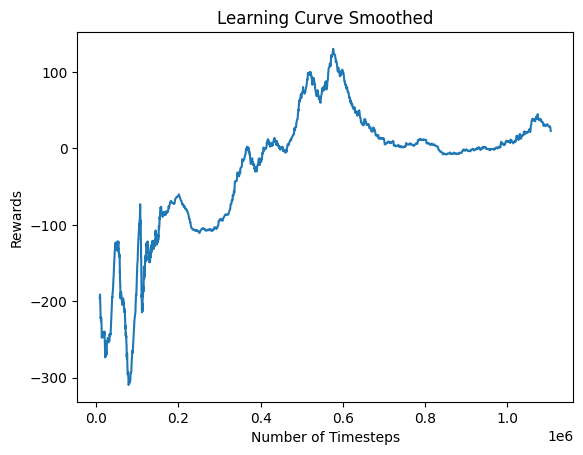

In [17]:
plot_results(log_dir)